# APLICACIÓN KMEANS EN TOP 10 ESTACIONES

**Contenido**

1. OPERACIONES Y SERVICIOS TERPEL LTDA. (Santiago)
2. OPERACIONES Y SERVICIO TERPEL LTDA. (Regiones)
3. Inversiones Enex
4. SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.
5. CL - Buses Vule S.A.
6. Petrobras Chile Red Ltda. Salida Norte
7. INVERSIONES ENEX S.A.
8. Petrobras Chile Red Ltda- Enea
9. SOCIEDAD COMERCIAL ANTUCO LTDA.
10. Comercial Albano Ltda.

El objetivo de este notebook es la implementación del algoritmo Kmeans a las estaciones con mayor número de ordenes de trabajo (OT), con el fin de extraer patrones de comportamiento. 


<div class="alert alert-info" style="margin: 20px">
Se decide crear este algoritmo con el fin de obtener mayor grado de detales en las OT de las base de datos. En otras palabras, se busca identificar clusters específicos, conservando el sentido semantico de la oración, a diferencia del anterior estructura LDA que nos permitió tener una visión general. </div>

# I. DISEÑO DEL ALGORITMO

#### Importar paquetes

In [1]:
import collections
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pprint import pprint
import numpy as np
from string import punctuation
from time import time
import os
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()

#### Estructura del algoritmo

In [2]:
# Tokenizar palabras
def word_tokenizer(text):    
    tokens = word_tokenize(text)   # tokenizes and stems the text
    # non_words = list(punctuation)  # removes punctuation 
    # text = ''.join([c for c in text if c not in non_words]) ---> Data ingresada ya está libre de puntuación
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words] # Posibilidad de extender stopwords
    return tokens

# Número óptimo de clústers
def elbow_method(sentences,figsize = (8,5),  namecol=None, nro_top=None, save = False,width_text = 0.83, height_text = 0.92):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    import warnings
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if len(sentences)<= 30:
                list_k = list(range(1,len(sentences)+1))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            elif len(sentences)> 30 and len(sentences)<= 70:
                list_k = list(range(2,len(sentences)+1,2))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)     

            else:     
                list_k = list(range(2,71,4))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            from kneed import KneeLocator
            kn = KneeLocator(list_k, elbow, curve='convex', direction='decreasing')
            print(f'Número óptimo de clústers: {kn.knee}')

            plt.rcParams.update({'figure.figsize':figsize})
            plt.xlabel('Número de clusters k')
            plt.ylabel('Suma de distancias cuadradas')
            plt.plot(list_k, elbow, 'bo-')
            plt.title('Método del Elbow')
            plt.text(width_text, height_text, f'k óptimo: {kn.knee}', transform=plt.gca().transAxes)
            plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
            if save :
                plt.savefig(f'{namecol} {nro_top} - Método del elbow.jpg', dpi= 200, quality=95)
            plt.show()

    except ValueError:
        print('You must enter at least two sentences')
        
# Algoritmo Kmeans
def cluster_sentences(sentences, nb_of_clusters):

    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    
    kmeans = KMeans(n_clusters=nb_of_clusters,max_iter=300)
    #kmeans.fit(tfidf_matrix)
    X_dist=kmeans.fit_transform(tfidf_matrix)**2  #Se calcula la distancia del cluster y se multiplica al cuadrado
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(i)

    Distancia=X_dist.sum(axis=1)  #Se calcula la distancia por columna de la matriz

    distDict={}  #Se traspasa a un diccionario con las distancias por cluster
    for key,val in clusters.items():
        distDict[key]=Distancia[val]

    representativos=[]   # Se guarda en una lista los valores mínimos de cada cluster (Menor distancia al centro mejor es el representativo)
    
    #Verificacion de los numeros de clusters
    #Si se intenta obtener los representativos de un número mas grande de cluster que el permitido, se procesa el número de clusters
    if len(distDict)<nb_of_clusters:
        nb_of_clusters=len(distDict)
        
    #Verificacion de los números de clústers
    for i in range(nb_of_clusters):
        representativos.append(np.where(distDict[i]==min(distDict[i]))[0][0])

    return dict(clusters),representativos

# Plot cantidad de sentences por cluster
def len_clusters(dic, n, namecol=None, nro_top=None, save = False, width = 0.6, color = "royalblue", figsize = (8,5)):
    keys = list(range(0,n))
    len_values = [len(dic[i]) for i in keys]
    plt.rcParams.update({'figure.figsize': figsize})
    plt.bar(keys,len_values , align='center', color = color, width = width)
    plt.title('Cantidad de OT por clúster')
    plt.xlabel('Clusters')
    plt.ylabel('Orden de Trabajo (OT)')
    plt.xticks(np.arange(min(keys), max(keys)+1, 1.0))
    if save:
        plt.savefig(f'{namecol} {nro_top} - Distribucion clusters .jpg', dpi= 200, quality=95)
    plt.show()

<div class="alert alert-success" style="margin: 20px">En todos los data frames ya está implementada la función word_cleaner() que permitió limpiar la base de datos. Para más información de esta función ir al segundo notebook.</div>


#### Importar Data Frame

In [3]:
df_total = pd.read_pickle('../2. Topic Modeling - LDA 24 topics/BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_total.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro Spa.,Carrete RetractilOTROOTRO,Normal 48 Horas,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en fechas,Más de 1 mes,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,2
1,8°,Combustibles El Volcan Ltda.,Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,cambio de graficas de equipos no esta contempl...,area de atencion combustible maria veronica go...,23
2,10°,LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.,Carrete RetractilOTROOTRO,Normal 24 Horas,PRECIERRE,Luis Almonacid,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,se visita eds para chequeo de dispensador el c...,area de atencion surtidor de diesel a ratos co...,3
3,1°,Soc. Imp. y Exp. Nuevo Amanecer Ltda. (SOCIEX),Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,remplazo de graficas no esta contemplado en es...,area de atencion combustible cambiar graficas ...,4
4,3°,Inmobiliaria e Inversiones San José Ltda (Vall...,Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,remplazo de graficas no esta contemplado en co...,area de atencion combustible solicita grafica ...,4


# II. RESULTADOS DE KMEANS - OBSERVACIONES

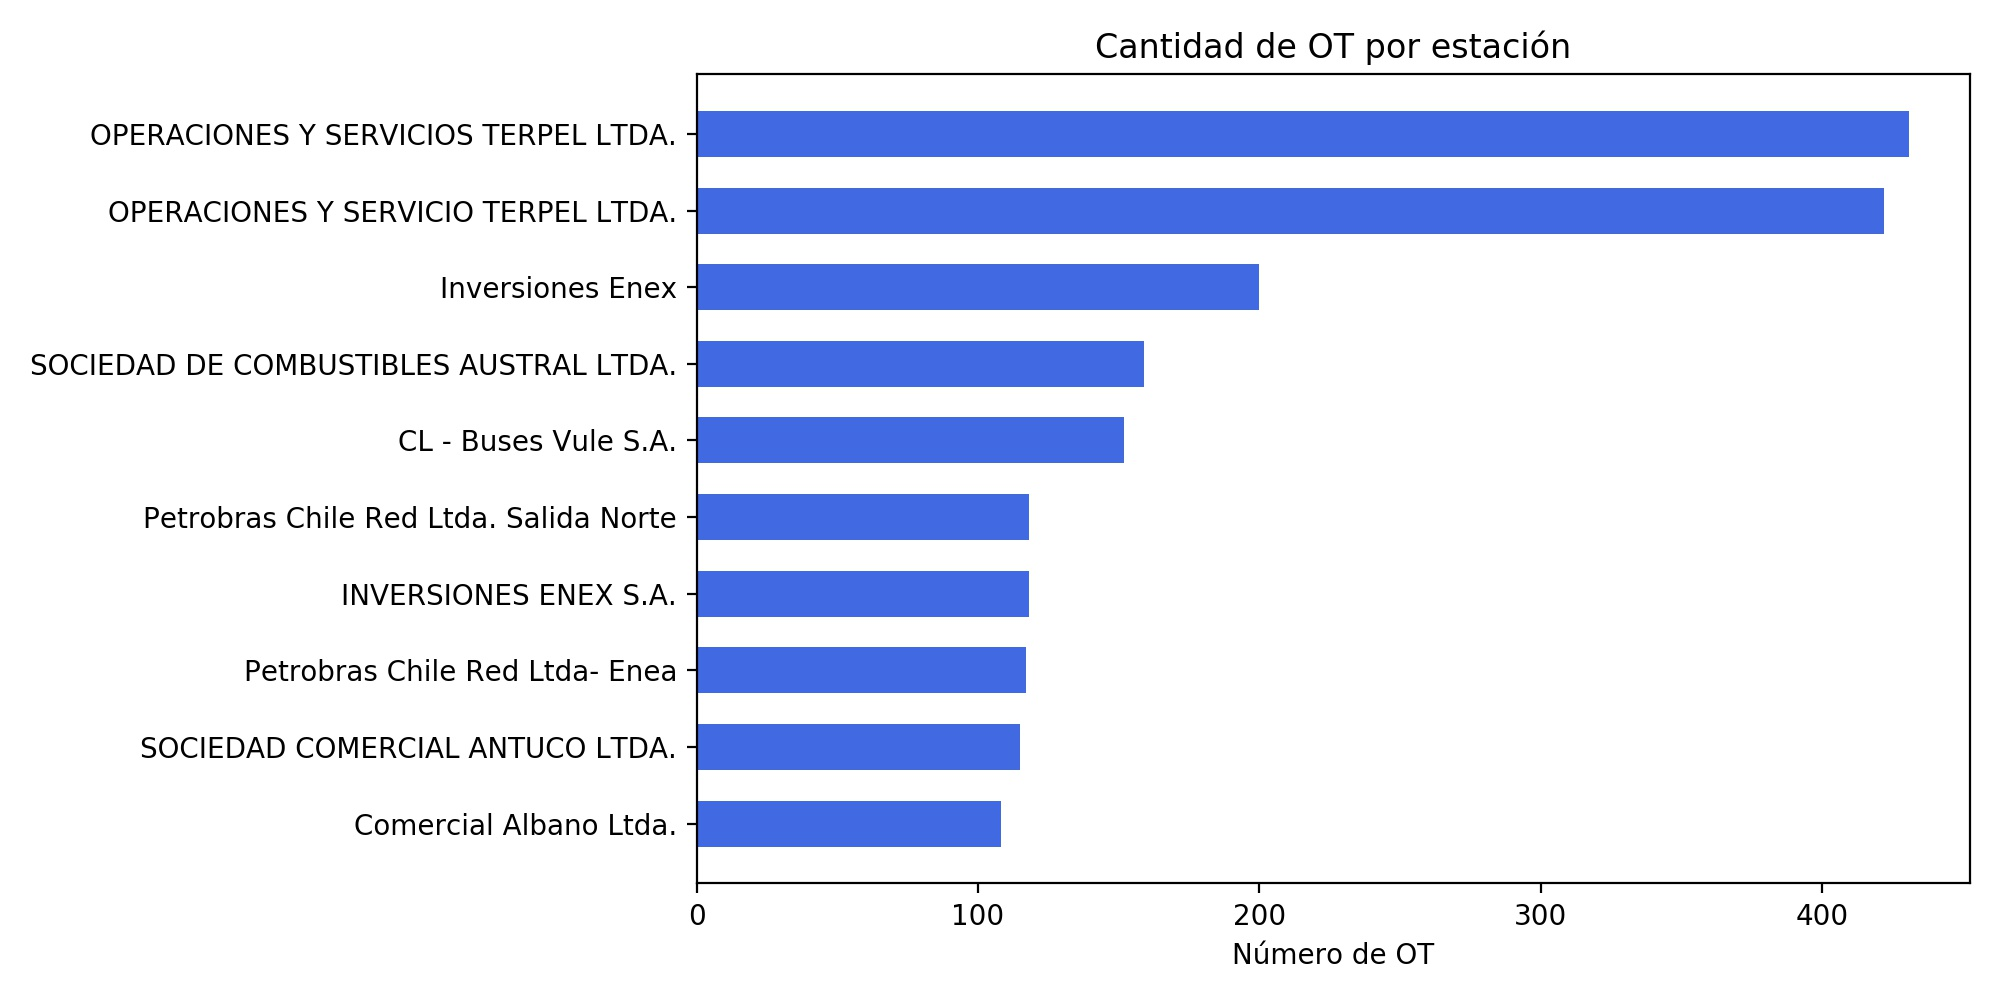

In [4]:
from IPython.display import Image
Image(filename='../1. OGC - Análisis y limpieza BD/2) Estacion.jpg',width=700, height=500)

### 1. OPERACIONES Y SERVICIOS TERPEL LTDA. (Santiago)

In [5]:
namecol = 'Estacion'
save = True

In [6]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIOS TERPEL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

416

Número óptimo de clústers: 14


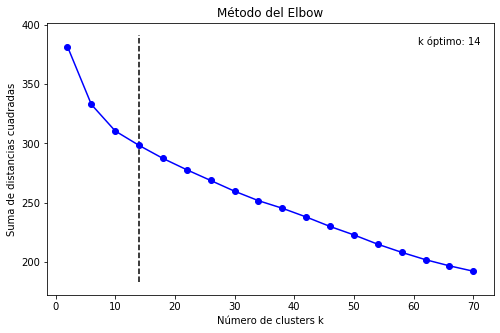

Wall time: 12.6 s


In [7]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=1, save=save)

In [8]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 14
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : incidencia es atendida bajo ot 1
	sentence  0 :  incidencia se cierra bajo la ot 1
	sentence  1 :  incidencia fue atendida bajo la ot 2
	sentence  2 :  llamado se cierra bajo ot llamado se cierra bajo ot
	sentence  3 :  llamado se cierra bajo ot 4 llamado se cierra bajo ot 4
	sentence  4 :  llamado atendido bajo la ot 6 llamado atendido bajo la ot 6
	sentence  5 :  se coordinara para realizar pruebas de linea y verificar despacho de productos a la brevedad posible llamado atendido bajo la ot 6 se coordinara para realizar pruebas de linea y verificar despacho de productos a la brevedad posible llamado atendido bajo la ot 6
	sentence  6 :  requerimiento atendido bajo la ot 1
	sentence  7 :  incidencia se cierra bajo ot 2
	sentence  8 :  incidencia es atendida bajo ot 0
	sentence  9 :  incidencia es atendida bajo ot 8
	sentence  10 :  incidencia es atendida bajo ot 7
	sentence  11 :  incidencia es atendida bajo ot 8
	sentence  12 :  incidencia es atendida bajo ot 7


In [9]:
# Clusters representativos (con n = 14)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : incidencia es atendida bajo ot 1
Cluster  1 : se realiza el cambio de 2 manguers rv 2 pistolas rv 1 whipe hose rv y 2 breackaway rv quedando ok se realiza el cambio de 2 mangueras rv 2 whipe hose rv y 2 breackaway rv quedando equipo operativo
Cluster  2 : se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos se realiza mantencion preventiva a lados 1 al 6 se realiza verificacion volumetrica con matraz de 20 litros a 32 bocas de 32 se revisan interior de equipos se revisan y prueban accesorios se cambia wipehose de diesel lado 4 roto por desgaste de mategial en el tiempo se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos oper

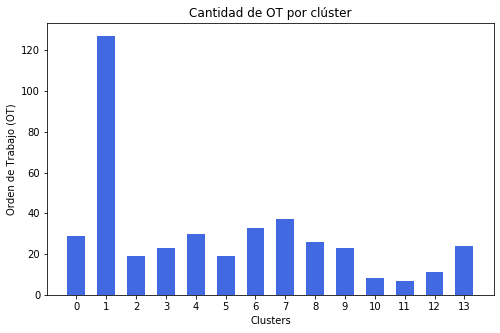

In [10]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=1, width = 0.6, save = save) 

### 2. OPERACIONES Y SERVICIO TERPEL LTDA. (Regiones)

In [11]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIO TERPEL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

412

Número óptimo de clústers: 26


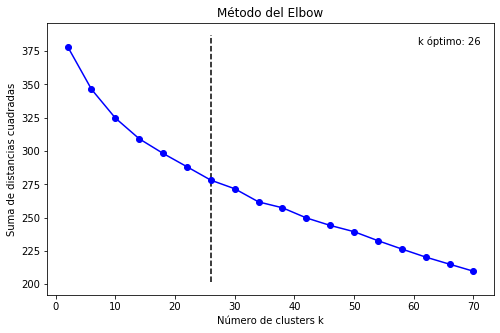

Wall time: 12 s


In [12]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=2, save = save)

In [13]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se cambia filtro de adblue comprado quedando equipo nornal en os 90200 ot 0 anterior se recircularon 80 litros de producto adblue los cuales 30 litros quedaron en bidones por encontrarse contaminado con agua se chequea equipo adblue encontrandose filtro saturado de inpurezas se cambia filtro quedando equipo con despacho normal
	sentence  0 :  se realiza cambio de placas de identificacion tk 1 gas97 capacidad 20m3 tk 2 gas95 capacidad 30m3 tk 4 producto diesel capacidad 30m3
	sentence  1 :  se chequea equipo de adblue por problemas electricos encontrandose motor de bomba de membrana defectuoso se solicita motor adblue 220 volt 195a 50 hz para su normalizacion se adjuntan fotos se cambia bomba de membrana piusi 220 volt por encontrarse danada se prueba equipo despachando adblue normal bomba de membrana comprada se chequea equipo de adblue por problemas electricos encontrandose motor de bomba de membrana defectuoso se solicita motor adblue 220 volt 195a 50 hz para s

In [14]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se cambia filtro de adblue comprado quedando equipo nornal en os 90200 ot 0 anterior se recircularon 80 litros de producto adblue los cuales 30 litros quedaron en bidones por encontrarse contaminado con agua se chequea equipo adblue encontrandose filtro saturado de inpurezas se cambia filtro quedando equipo con despacho normal
Cluster  1 : sin observaciones se realiza calibracion de dispensadores 1 2 3 4 5 6 7 y 8 con un total de bocas calibradas de 20 que cuenta la estacion se chequean fugas interior y exterior se limpian dispensadores interior se chequea agua en estanque se chequea parada de emergencia se cambia 1 destorcedor y 1 breakaway 1
Cluster  2 : se realiza el cambio de 1 pistola 1 quedando equipo operativo
Cluster  3 : se realiza visita a estacion encontrando dispensador 8 boca 20 con pistola defectuosa se procede al cambio de esta quedando boca operativa se recircula producto para pruebas de funcionamiento se realiza visita a estacion encontrando dispensador 8 

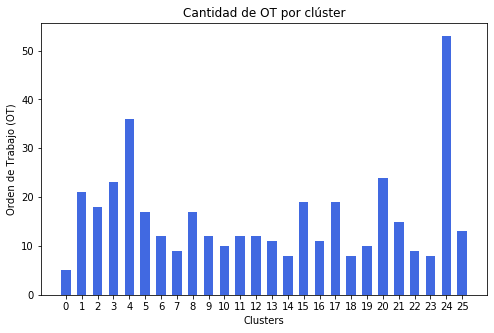

In [15]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=2, width = 0.6, save=save)

### 3. Inversiones Enex

In [16]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Inversiones Enex'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

195

Número óptimo de clústers: 22


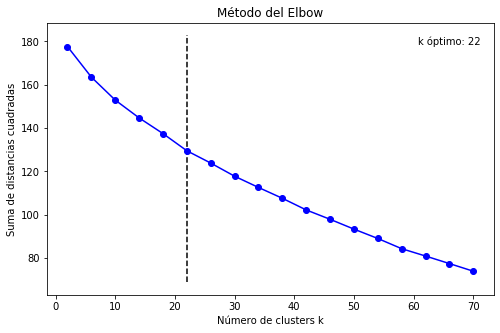

Wall time: 8.92 s


In [17]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=3, save=save)

In [18]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza revision de dispensador boca 14 pd por venta que sigue avanzando se detecta filtracion por manifold superior el cual al estar filtrando generaba que avance una vez cortada la pistola se realizo reparacion de la filtracion quedando operativo se realiza revision de dispensador boca 14 pd por venta que sigue avanzando se detecta filtracion por manifold superior el cual al estar filtrando generaba que avance una vez cortada la pistola se realizo reparacion de la filtracion quedando operativo
	sentence  0 :  se rechaza orden por no corresponder a contrato sgs
	sentence  1 :  requerimiento no corresponde a contrato sgs
	sentence  2 :  se realiza revision de dispensador boca 14 pd por venta que sigue avanzando se detecta filtracion por manifold superior el cual al estar filtrando generaba que avance una vez cortada la pistola se realizo reparacion de la filtracion quedando operativo se realiza revision de dispensador boca 14 pd por venta que sigue avanzando s

In [19]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza revision de dispensador boca 14 pd por venta que sigue avanzando se detecta filtracion por manifold superior el cual al estar filtrando generaba que avance una vez cortada la pistola se realizo reparacion de la filtracion quedando operativo se realiza revision de dispensador boca 14 pd por venta que sigue avanzando se detecta filtracion por manifold superior el cual al estar filtrando generaba que avance una vez cortada la pistola se realizo reparacion de la filtracion quedando operativo
Cluster  1 : tarro metalico queda vacio al retiro de recinto se realiza cambio de 5 pistolas de 12 en bocas 3 gas 95 4 gas 93 7 gas 95 8 gas 93 16 gas 93 24 gas 93 4 pistolas de 34 en bocas 5 diesel 9 diesel 13 diesel 21 diesel recirculando producto quedando operativo
Cluster  2 : se visita eds por requerimiento en la cual indican que fue atendido y solucionado el dia bajo la ot 6 por reparacion de filtracion en oring de manifold superior de dispensador en isla 4 dispensadores o

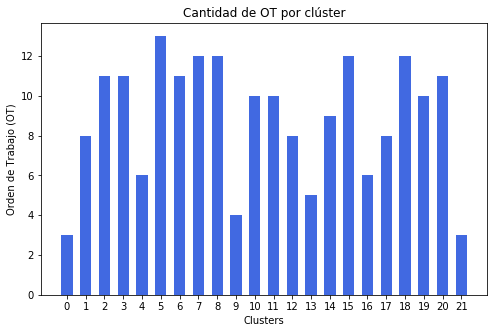

In [20]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=3, width = 0.6, save=save)

### 4. SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.

In [21]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

153

Número óptimo de clústers: 30


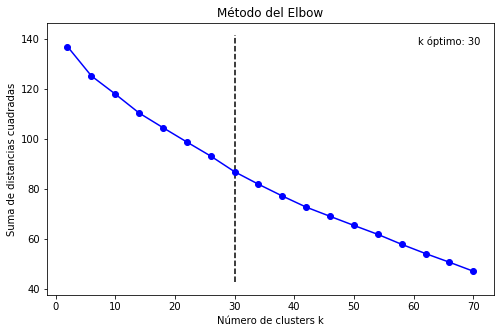

Wall time: 7.95 s


In [22]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=4, save=save)

In [23]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se realiza visita a estacion encontrando filtracion en medidor de dispensador 9 y 10 se procede al cambio de 4 tapas y 4 oring tapa medidor luego se realiza prueba de presion en equipo vedeer root volviendo todas sus funciones a la normalidad se recircula producto para pruebas de funcionamiento despachando sin presentar filtracion se realiza visita a estacion encontrando filtracion en medidor de dispensador 9 y 10 se procede al cambio de 4 tapas y 4 oring tapa medidor luego se realiza prueba de presion en equipo vedeer root volviendo todas sus funciones a la normalidad se recircula producto para pruebas de funcionamiento despachando sin presentar filtracion
	sentence  0 :  incidencia fue atendida el 0506 por gonzalo barria quien informa que falla se encuentra en tapas oringde medidor de dispen 89 se corta valvula de emergencia y se levanta presion en consola vr para que puedan vender con disp 7 queda pendiente un medidor wayne y 02 valvulas check medidormedidor s

In [24]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se realiza visita a estacion encontrando filtracion en medidor de dispensador 9 y 10 se procede al cambio de 4 tapas y 4 oring tapa medidor luego se realiza prueba de presion en equipo vedeer root volviendo todas sus funciones a la normalidad se recircula producto para pruebas de funcionamiento despachando sin presentar filtracion se realiza visita a estacion encontrando filtracion en medidor de dispensador 9 y 10 se procede al cambio de 4 tapas y 4 oring tapa medidor luego se realiza prueba de presion en equipo vedeer root volviendo todas sus funciones a la normalidad se recircula producto para pruebas de funcionamiento despachando sin presentar filtracion
Cluster  1 : queda pendiente pistola 12 se realiza el cambio de 1 pistola y una funda roja quedando equipo operativo
Cluster  2 : se realiza visita a estacion encontrando boca 3 gas 93 con manguera danada por desgaste de uso se procede al cambio de esta quedando boca operativa y sin filtracion se recircula producto para

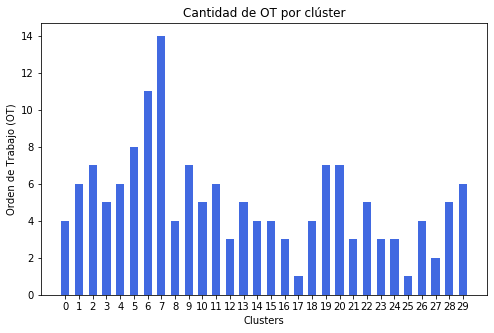

In [25]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=4, width = 0.6, save=save)

### 5. CL - Buses Vule S.A.

In [26]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'CL - Buses Vule S.A.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

151

Número óptimo de clústers: 18


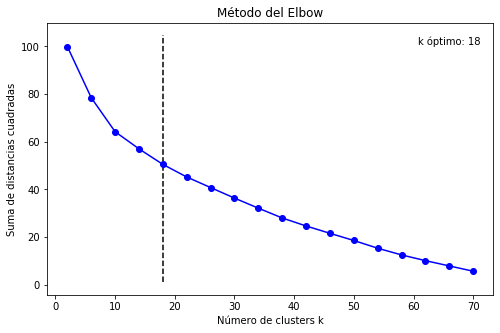

Wall time: 7.47 s


In [27]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=5, save=save)

In [28]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 18
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01 se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01
	sentence  0 :  incidencia fue reasignada a otra contratista
	sentence  1 :  se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01 se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01
	sentence  2 :  se chequea falla detectando mecanismo de partida malo se revisa y realiza adaptacion para solucion quesando operativo en un 100 se chequea falla detectando mecanismo de partida mal

In [29]:
# Clusters representativos (con n = 18)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01 se chequea falla y se detecta problema en pistola 34 con fuga se realiza cambio de pistola 34 y se eprueba quedandomoperativa 100 repussto pistola 34 codigo p14776 cantidad 01
Cluster  1 : ods mal emitida
Cluster  2 : se realiza el cambio de 1 pistola 1 quedando equipo operativo
Cluster  3 : se realiza limpieza y mantencion de filtro malla quedando equipo operativo
Cluster  4 : mp se realizara cuando se repare surtidor n 2 se efectua proceso de mantencion preventiva de estanque y surtidores se realiza revision limpieza y verificacion volumetrica a los surtidores 1 y 2 con matraz de 20 lts se cambian 2 filtros de alta capacidad debido a flujo lento mejorando considerablemente 65 litros por minutos aprox se reaprietan porta pistolas boca 1 y 2 ademas se remarcan adhesivos bocaestanque regla incompleta 

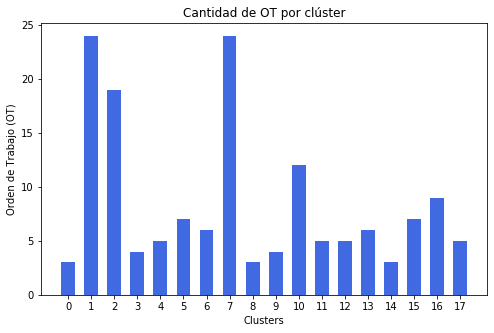

In [30]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol, nro_top=5, width = 0.6, save=save)

### 6. Petrobras Chile Red Ltda. Salida Norte

In [31]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Petrobras Chile Red Ltda. Salida Norte'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

108

Número óptimo de clústers: 22


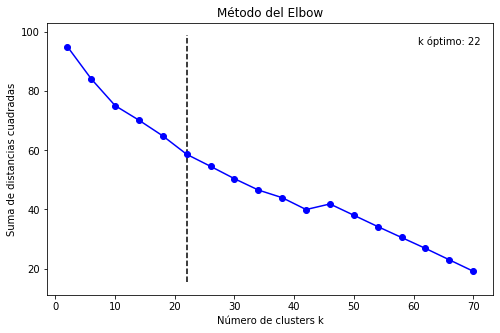

Wall time: 7.47 s


In [32]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=6, save=save)

In [33]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : isla queda operativa isla 4 presenta breakaway de gasolinas cortado se reemplaza y prueba se habilita para ventas
	sentence  0 :  isla queda operativa isla 1 presenta falla en corte automatico de pisyola de gasolinas se reemplaza y prueba se habilita para ventas
	sentence  1 :  seutiliza un breakaway vr p16674 isla queda operativa falla corresponde a isla 3 equipo presenta breakaway de gasolinas cortado se reemplaza y prueba se habilita para ventas
	sentence  2 :  se utiliza un breakaway 34 convencional p 13430 isla queda operativa isla 5 presenta breakaway diesel cortado se reemplaza y prueba se habilita para ventas
	sentence  3 :  se utiliza un wiphose 34 p16323 un breakaway 34 p13430 una manguera 34x32m p14516 y una pistola 34 p14776 isla queda operativa isla 7 presenta breakaway diesel cortado y wiphose danado cliente se lleva pistola y manguera con el vehiculo se reponen wiphose breakaway manguera swivel y pistola 34 convencionales se prueba y habilita para 

In [34]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : isla queda operativa isla 4 presenta breakaway de gasolinas cortado se reemplaza y prueba se habilita para ventas
Cluster  1 : alarma l5 disipada alarma l5 corresponde a tank sump 1 diesel con agua se retiran 200 litros se limpia sump y sensor alarma l5 disipada se deja un tambor en zona indicada por la administracion alarma q1 corresponde a prueba periodica necesaria se fuerza prueba no se puede eliminar alarma se requiere reseteo del equipo no se autoriza a resetear por flujo de ventas alto al momento de la visita se indica que se va a generar una nueva ot para atender la alarma durante dia de enor flujo de ventas alarma no condiciona ventas
Cluster  2 : incidencia sera atendida bajo ot 26664
Cluster  3 : islas quedan operativas chequeo de pistolas diesel alto galonaje fundas de pistola isla 12 master y satelite danadas se reemplazan se habilita para ventas
Cluster  4 : islas operativas se indica que equipos ya fueron revisados durante mantencion preventiva
Cluster  5 : 

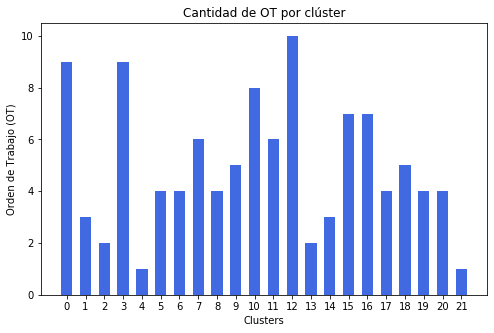

In [35]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=6, width = 0.6, save =save)

### 7. INVERSIONES ENEX S.A.

In [36]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'INVERSIONES ENEX S.A.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

116

Número óptimo de clústers: 22


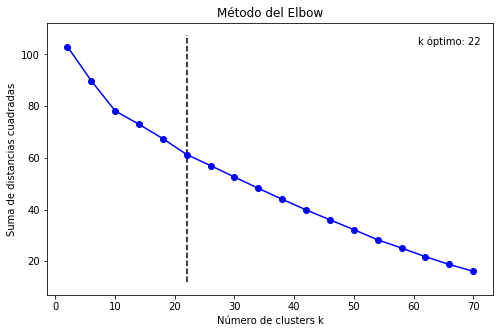

Wall time: 7.5 s


In [37]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=7, save = save)

In [38]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : mantencion preventiva se calibran 32 de 32
	sentence  0 :  mantencion preventiva se calibran 32 de 32
	sentence  1 :  mantencion preventiva se calibran 32 de 32
	sentence  2 :  mantencion preventiva se calibran 26 de 26
	sentence  3 :  se realiza mantencion preventiva se calibran 10 bocas
	sentence  4 :  fechas reales hora inicio 1500hrs inicio mantencion hora cierre 2000 se realiza mantencion preventiva se calibran 27 bocas
	sentence  5 :  mantencion preventiva se calibran 32 de 32
Cluster 1 : se visita eds encontrando pistola de 1 de dispensador n 9 en mal estado por uso se cambia pistola 1 cdgp14781 quedando en funcionamiento normal se visita eds encontrando pistola de 1 de dispensador n 9 en mal estado por uso se cambia pistola 1 cdgp14781 quedando en funcionamiento normal
	sentence  0 :  se visita eds encontrando pistola de 1 de dispensador n 9 en mal estado por uso se cambia pistola 1 cdgp14781 quedando en funcionamiento normal se visita eds encontrando pis

In [39]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : mantencion preventiva se calibran 32 de 32
Cluster  1 : se visita eds encontrando pistola de 1 de dispensador n 9 en mal estado por uso se cambia pistola 1 cdgp14781 quedando en funcionamiento normal se visita eds encontrando pistola de 1 de dispensador n 9 en mal estado por uso se cambia pistola 1 cdgp14781 quedando en funcionamiento normal
Cluster  2 : ods mal emitida
Cluster  3 : se visita esd para comenzar los trabajos de mantencionse comienza limpiando camaras de sump de dispensadores cabezales de dispenzadores camaras sump de bombas se obserba dispensador n 4 con problemas en el despacho de gasolina 95 y cortando ventasse intercambia medidores de diesel x gasolina de 93 se prueba cambiando la falla a boca de diesel se desmonta medidor para desarmar y limpiar se realizan pruebas recirculando quedando operativo y sin fallas se chequea no existan filtraciones continuando con los trabajos de mantencion se calibran dispensadores se cambian 02 filtro cdg p14187 de gasolina

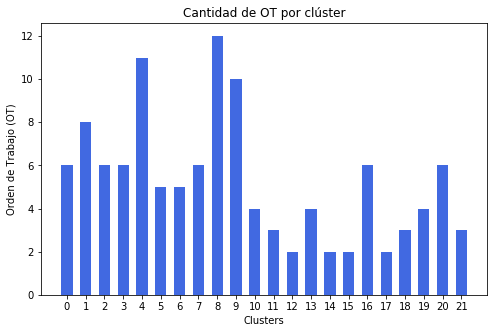

In [40]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=7, width = 0.6, save = save)

### 8. Petrobras Chile Red Ltda- Enea

In [41]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Petrobras Chile Red Ltda- Enea'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

110

Número óptimo de clústers: 14


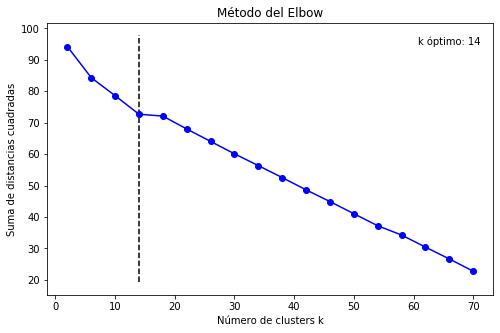

Wall time: 7.39 s


In [42]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=8, save = save)

In [43]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 14
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : 
	sentence  0 :  disp10 95 se realizo remplazo de un breckawey rv opw disp10 95 se realizo remplazo de un breckawey rv opw
	sentence  1 :  incidencia duplicada isla 7 se encuentra operativa al momento de la visita sin fallas en operacion equipo fue reparado en visita anterior incidencia duplicada
	sentence  2 :  isla operativa isla 6 se encuentra operativa y sin fallas al momento de la visita se indica que equipo ya fue revisado el dia 19 de julio por tecnico de mantencion preventiva
	sentence  3 :  isla continua operativa chequeo de isla 78 se verifica funcionamiemto de accesorios vr y diesel no se detecta falla en retencion de pistolas ni fuga hacia srv se fuerza partida deequipo no se presenta falla se habilita para ventas
	sentence  4 :  isla continua operativa isla 8 se encuentra operativa teclado preset sin fallas serevisa funcionamiento y cableado sin detectar problemas
	sentence  5 :  seutiliza un breakaway vr p16674 una manguera vr p14517 y una pistola v

In [44]:
# Clusters representativos (con n = 14)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : 
Cluster  1 : isla queda operativa isla 910 presenta flujo de despachos diesel en 20 lmin se reemplaza filtro flujo queda en 35 lmin se habilita para ventas
Cluster  2 : se realiza cambio de pistola rv en dispensador 7 ya que se encintraba defectuosa se realiz cambio de pistola 1 ya que se encontraba con filtracion se rralizan pruebas quedsndo operativas se recirculan 27 lts para realizar pruebas mantencion correctiva
Cluster  3 : isla queda operativa isla 8 presenta falla en retencion de producto de pistola de gasolinas se reemplaza y prueba se habilita para ventas
Cluster  4 : incidencia sera atendida dentro de mantencion preventiva ot 20834
Cluster  5 : programa mantencion preventiva mes mayo 2019 mp calibracion verificacion detector de fuga se realiza verificscion volumetrica a disp 12 34 56 78 y 910 recirculando producto 93 97 y diesel a estanque correspondiente se realiza prueba de detectores de fuga se realiza cambio de 1 pistola 34 conv se realiza instalacion de ad

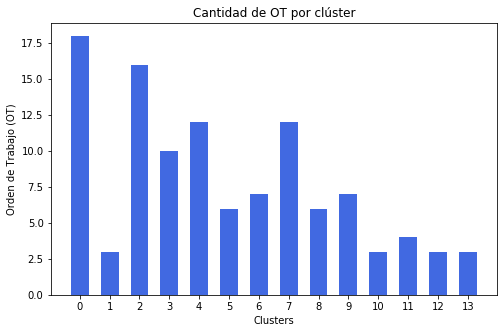

In [45]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=8, width = 0.6, save = save)

### 9. SOCIEDAD COMERCIAL ANTUCO LTDA.

In [46]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'SOCIEDAD COMERCIAL ANTUCO LTDA.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

113

Número óptimo de clústers: 26


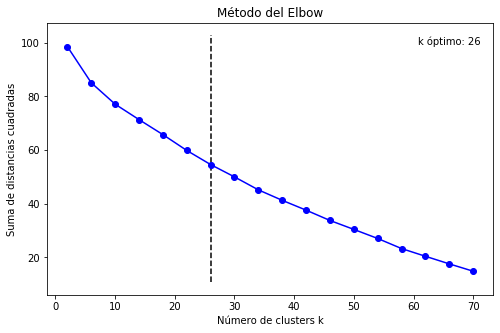

Wall time: 7.42 s


In [47]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=9, save = save)

In [48]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo
	sentence  0 :  son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo
	sentence  1 :  en pos 2 es reemplazada 01 mqnguera de 1 por 5 mts por estar perforada equipo queda operativo en pos 2 es reemplazada 01 mqnguera de 1 por 5 mts por estar perforada equipo queda operativo
	sentence  2 :  en boca 2 diesel 3s reemplazada 01 correa 95 poren boca 2 diesel 3s reemplazada 01 correa 95 por 815 por rstar 3n mal estado equipo queda operativo ademas equipomes realizado cold star configurado quedando ok por estar bloqueado por por error 49 luego corte de energia 815 por rstar 3n mal estado equipo queda operativo en boca 2

In [49]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo son reemplazados 02 swivel 34 en pos 3 y 4 bocas 93 por estar filtrando por uso equipo queda operativo
Cluster  1 : se realiza el cambio de 1 pistola 1 quedando equipo operativo
Cluster  2 : incidencia sera atendida bajo ods 2
Cluster  3 : disp 1 se chequea disp por aparente falla se encontro funcionando ok disp 1 se chequea disp por aparente falla se encontro funcionando ok
Cluster  4 : se realiza mantencion preventiva a lados 1 al 12 se realiza verificacion volumetrica con matraz de 20 litros se revisan interior de equipos se revisan y prueban accesorios se revisan y limpian spill descargas se pintan tapas de descargas quedan todos los equipos operativos se realiza mantencion preventiva a lados 1 al 12 se realiza verificacion volumetrica con matraz de 20 litros se revisan interior de equipos se revisan y prueban accesorios se revisan y limpian spill descargas se pintan 

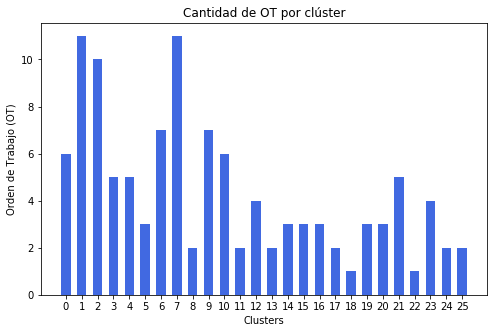

In [50]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=9, width = 0.6, save = save)

### 10. Comercial Albano Ltda.

In [51]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Comercial Albano Ltda.'] 
sentences = [sent for sent in df['Observación']]
len(sentences)

101

Número óptimo de clústers: 22


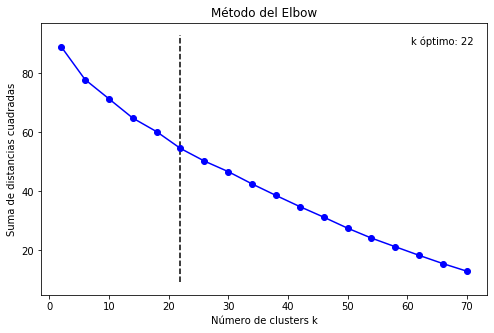

Wall time: 7.86 s


In [52]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=10, save = save)

In [53]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : se verifica calibracion en bocas de gas 93 en los dispensadores n 12 y 34 las cuales estan dentro de las tolerancias establecidas se chequea el estado de los dispenser sump los cuales no presentan filtracion camara de albanileria del tk n 4 no presenta filtracion zonda de medicion no presenta suciedad en los flotadores se realiza prueba de operatividad de detector de fuga de gas 93 el cual esta operativo se realiza prueba de fuga en linea la cual en un periodo de 30 min la presion se mantiene en 36 psi se verifica el estado de valvula de sobrellenado la cual esta en buen estado se comparan mediciones entregadas por regla vs veeder root en donde hay diferencias en el inventario de el tk estacion cuenta con tablas de calibracion pero no se sabe con certeza si las tablas corresponde al tk n 4 ya que el domo del tk no cuenta con placa de identificacion segun los datos obtenidos se saca el diametro del tk n 4 de gas 93 el cual corresponde a 242cm en comparacion a la d

In [54]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : se verifica calibracion en bocas de gas 93 en los dispensadores n 12 y 34 las cuales estan dentro de las tolerancias establecidas se chequea el estado de los dispenser sump los cuales no presentan filtracion camara de albanileria del tk n 4 no presenta filtracion zonda de medicion no presenta suciedad en los flotadores se realiza prueba de operatividad de detector de fuga de gas 93 el cual esta operativo se realiza prueba de fuga en linea la cual en un periodo de 30 min la presion se mantiene en 36 psi se verifica el estado de valvula de sobrellenado la cual esta en buen estado se comparan mediciones entregadas por regla vs veeder root en donde hay diferencias en el inventario de el tk estacion cuenta con tablas de calibracion pero no se sabe con certeza si las tablas corresponde al tk n 4 ya que el domo del tk no cuenta con placa de identificacion segun los datos obtenidos se saca el diametro del tk n 4 de gas 93 el cual corresponde a 242cm en comparacion a la documentaci

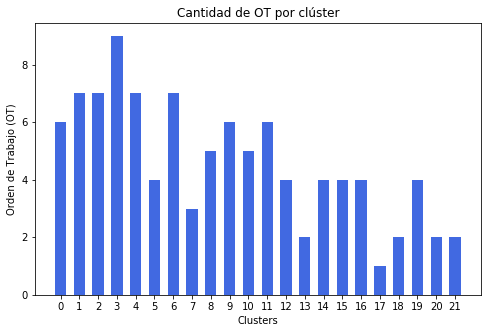

In [55]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=10, width = 0.6, save = save)

# III. RESULTADOS DE KMEANS - REQUERIMIENTOS

### 1. OPERACIONES Y SERVICIOS TERPEL LTDA. (Santiago)

In [56]:
namecol = 'REQ Estacion'
save = True

In [57]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIOS TERPEL LTDA.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

416

Número óptimo de clústers: 22


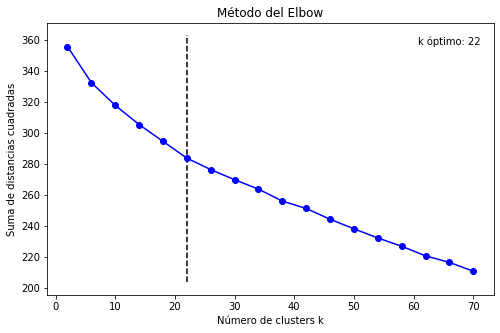

Wall time: 10.7 s


In [58]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=1, save = save)

In [59]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : area de atencion surtidor 1 gas de 93 manguera arrancada de breakaway solicitado por jenniffer palma fono
	sentence  0 :  area de atencion surtidor 1 2 producto gas 95 en una cada uno no han entrergado la carga correspondiente lo que ha provocado serias molestias y reclamos de nuestros clientes solicitado por fco valderrama albarran fono
	sentence  1 :  area de atencion teclado se salio de surtidor se despego y desconecto solicitado por nancy reyes fono
	sentence  2 :  area de atencion surtidor con ruido solicitado por alejandra aedo fono
	sentence  3 :  area de atencion surtidor 1 gas de 93 manguera arrancada de breakaway solicitado por jenniffer palma fono
	sentence  4 :  area de atencion por favor dejar sin efecto reporte numero 4 error de reporte las pistolas se encuentran bien solicitado por waldo gomex fono
	sentence  5 :  area de atencion sin venta de 93 y 95 emergencia solicitado por apf fono
	sentence  6 :  area de atencion se solicita a quien correspond

In [60]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : area de atencion surtidor 1 gas de 93 manguera arrancada de breakaway solicitado por jenniffer palma fono
Cluster  1 : area de atencion manguera diesel isla 2 rota no se puede despachar combustible solicitado por margarita vizcarra fono
Cluster  2 : surtidor 1 pistola 93 y 95 cortan a cada rato
Cluster  3 : surtidores lentos atiende de emergencia sgs 2 2 19
Cluster  4 : programacion mantencion preventiva
Cluster  5 : area de atencion pistola de kerosene no despacha combustible solicitado por oscar pena fono
Cluster  6 : area de atencion manguera isla 5 manguera de diesel fuga de combustible por manguera solicitado por yessica opazo fono
Cluster  7 : gasolina 97 filtrando por union entre manguera y pistola isla 1
Cluster  8 : surtidor 4 gas 93 no despacha combustible
Cluster  9 : instalacion detectores de fuga
Cluster  10 : manguera isla 1 boca 16 manguera de gasolina 93 con fuga de combustible
Cluster  11 : surtidor 6 gas de 95 combustible se filtra por boca de pistola
Clu

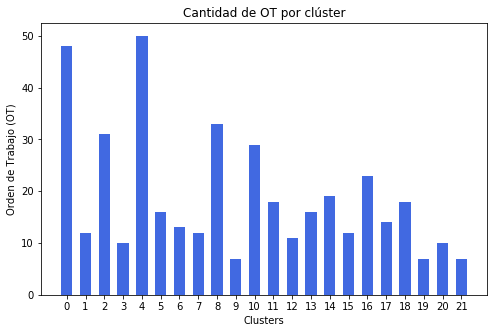

In [61]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=1, width = 0.6, save = save) 

### 2. OPERACIONES Y SERVICIO TERPEL LTDA. (Regiones)

In [62]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'OPERACIONES Y SERVICIO TERPEL LTDA.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

412

Número óptimo de clústers: 14


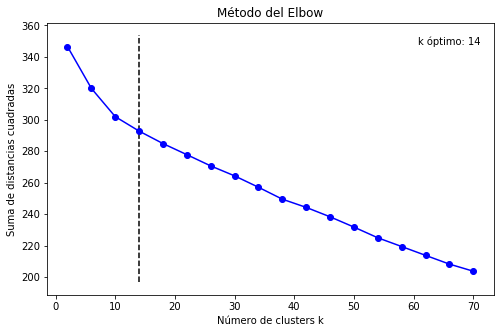

Wall time: 10.7 s


In [63]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=2, save = save)

In [64]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 14
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : area de atencion tapas de surtidor isla 3 de alto galonaje se encuentran abiertas solicitado por priscilla munoz fono
	sentence  0 :  area de atencion diferencias reconciliacion numerales con asistencia de orpak remoto martes 1000 am solicitado por apf fono
	sentence  1 :  area de atencion la isla 1 posicion 2 se queda pegada en pos nos dice despachando solicitado por erick sepulveda fono
	sentence  2 :  area de atencion tapa del cano de descarga de diesel se encuentra danada no se le puede colocar candado solicitado por erick sepulveda fono
	sentence  3 :  area de atencion la pistola de alto galonaje de la isla 3 posicion 5 se encuentra con filtracion solicitado por erick sepulveda fono
	sentence  4 :  area de atencion filtracion en pistolas de diesel isla 1 y 3 solicitado por nicolas carrillo fono
	sentence  5 :  area de atencion mangera cortada solicitado por alvaro vega fono
	sentence  6 :  area de atencion surtidores de la isla 1 no inician carga de combusti

In [65]:
# Clusters representativos (con n = 14)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : area de atencion tapas de surtidor isla 3 de alto galonaje se encuentran abiertas solicitado por priscilla munoz fono
Cluster  1 : manguera de diesel surtidor 6 danada
Cluster  2 : se solicita cambio de manguera y pistola en isla de alto galonaje por perdida de combustible ademas se solicita cambio de fundas
Cluster  3 : pistola danada con fuga de combustible alto galonaje diesel
Cluster  4 : pistola gasolina 93 quebrada
Cluster  5 : filtracion de combustible en torcedores o uniones entre manguera y pistolas isla 2 e isla 3 surtidores de alto galonaje son 4 pistolas
Cluster  6 : programa mantencion preventiva
Cluster  7 : surtidor 1 y 2 de alto galonaje despachan lentos
Cluster  8 : breakaway danado pistola diesel alto galonaje
Cluster  9 : fuga de combustible en manguera diesel isla 2 no es de alto galonaje mangueras rotas con alambres a la vista gasolina 93 isla 1 y gasolina 93 isla 2
Cluster  10 : programacion mantencion preventiva
Cluster  11 : area de atencion fundas 

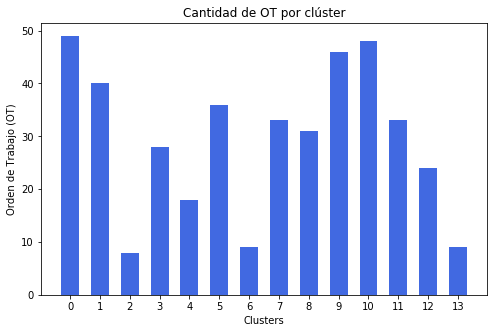

In [66]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=2, width = 0.6, save = save)

### 3. Inversiones Enex

In [67]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Inversiones Enex'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

195

Número óptimo de clústers: 30


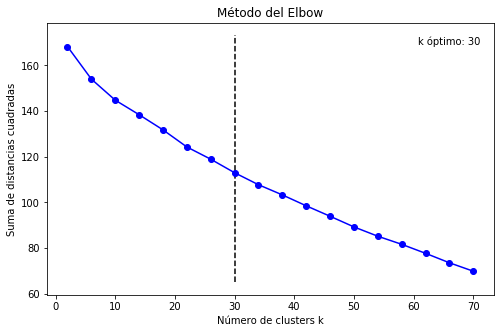

Wall time: 7.83 s


In [68]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=3, save = save)

In [69]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : isla 7 surtidor de 93 filtra combustible manguera en la parte de arriba en la union
	sentence  0 :  isla 7 surtidor de 93 filtra combustible manguera en la parte de arriba en la union
	sentence  1 :  desconexion de manguera con el surtidor vehiculo se pone en marcha con pistola puesta
	sentence  2 :  jefe de playa
	sentence  3 :  manguera de surtidor de gasolinas desprendida en la union con el surtidor
Cluster 1 : programacion mantencion preventiva
	sentence  0 :  programacion mantencion preventiva
	sentence  1 :  programacion mantencion preventiva
	sentence  2 :  area de atencion mantencion preventiva solicitado por fono
	sentence  3 :  programacion mantencion preventiva
	sentence  4 :  area de atencion mantencion preventiva solicitado por fono
	sentence  5 :  area de atencion mantencion preventiva solicitado por fono
	sentence  6 :  programacion mantencion preventiva
	sentence  7 :  programacion mantencion preventiva
	sentence  8 :  programacion mantencion prev

In [70]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : isla 7 surtidor de 93 filtra combustible manguera en la parte de arriba en la union
Cluster  1 : programacion mantencion preventiva
Cluster  2 : surtidores de gasolina en isla 3 no cortan la carga
Cluster  3 : fuga de combustible al momento de realizar carga en pistola surtidor alto galonaje
Cluster  4 : tapas de contenedores de mediciones de combustible diesel gas 97 y gas 93 danadas
Cluster  5 : surtidor de alto galonaje con problema en palanca de carga
Cluster  6 : surtidores 7 y 8 diesel alto galonaje en isla n 4 con despacho lento
Cluster  7 : surtidor 2 no despacha gasolina 97 en ambos lados
Cluster  8 : solicito retiro de agua tk n 1 combustible diesel
Cluster  9 : surtidor de alto galonaje isla 11 filtracion de combustible manguera pistola
Cluster  10 : gas 95 boca 5 surtidor 2 cae combustible por destorcedor
Cluster  11 : surtidores diesel alto galonaje entregan producto en forma lenta
Cluster  12 : conexion manguera surtidor danada por torcion
Cluster  13 : mangu

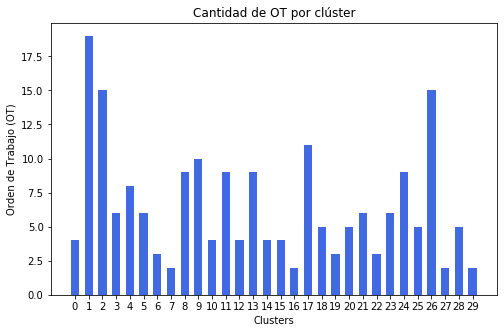

In [71]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=3, width = 0.6, save = save)

### 4. SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.

In [72]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'SOCIEDAD DE COMBUSTIBLES AUSTRAL LTDA.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

153

Número óptimo de clústers: 26


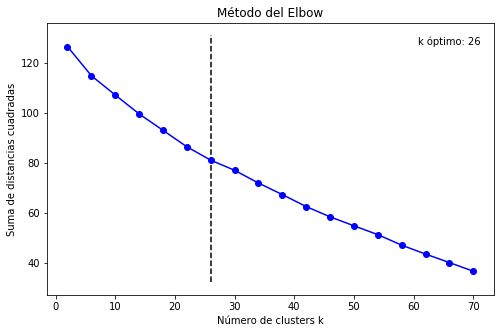

Wall time: 7.57 s


In [73]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=4, save = save)

In [74]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 26
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : fuga de combustible isla n 2 de diesel bomba centrifuga o meter se solicita mantencion a la brevedad
	sentence  0 :  fuga de combustible isla n 2 de diesel bomba centrifuga o meter se solicita mantencion a la brevedad
Cluster 1 : programacion mantencion preventiva
	sentence  0 :  area de atencion mantencion preventiva solicitado por fono
	sentence  1 :  programacion mantencion preventiva
	sentence  2 :  programacion mantencion preventiva
	sentence  3 :  area de atencion mantencion preventiva solicitado por fono
	sentence  4 :  programacion mantencion preventiva
	sentence  5 :  programacion mantencion preventiva
	sentence  6 :  programacion mantencion preventiva
	sentence  7 :  programacion mantencion preventiva
	sentence  8 :  programacion mantencion preventiva
	sentence  9 :  programacion mantencion preventiva
	sentence  10 :  programacion mantencion preventiva
	sentence  11 :  programacion mantencion preventiva
	sentence  12 :  programacion mantencion preventiv

In [75]:
# Clusters representativos (con n = 26)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : fuga de combustible isla n 2 de diesel bomba centrifuga o meter se solicita mantencion a la brevedad
Cluster  1 : programacion mantencion preventiva
Cluster  2 : al cargar con pistola diesel isla 1 filtra combustible
Cluster  3 : area de atencion marcador cuenta litros no funciona solicitado por erick torres o fono
Cluster  4 : veeder root acusa alarma apagado dflp no pasa p catas lin al dar esta alarma se bloqueo el estanque 2 y no se puede cargar en los surtidores gasolina de 95 ni de 97 vpower
Cluster  5 : fundas danadas diesel surtidor 2 isla 1 diesel surtidor 3 y 4 isla 2 diesel surtidor 8 isla 5 gas95 surtidor 6 isla 3 gas97 surtidor 5 isla 3 diesel surtidor 5 isla 3 y en el surtidor 9 falta la funda favor venir a reparar
Cluster  6 : boca 4 no corta en venta indicada
Cluster  7 : area de atencion manguera isla 1 lado 1 diesel con malla a la vista manguera isla 2 lado 3 gas 93 gas 95 y diesel con malla a la vista solicitado por betzabe jara fono
Cluster  8 : se solic

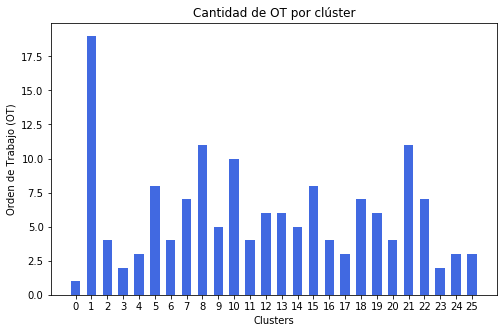

In [76]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=4, width = 0.6, save = save) 

### 5. CL - Buses Vule S.A.

In [77]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'CL - Buses Vule S.A.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

151

Número óptimo de clústers: 22


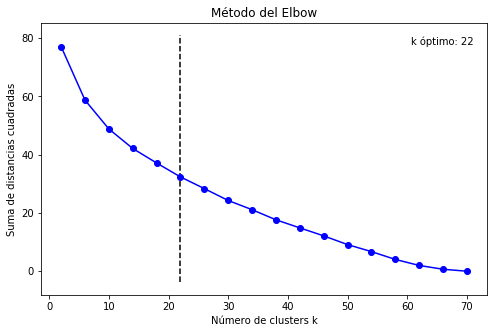

Wall time: 7.1 s


In [78]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=5, save = save)

In [79]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : surtidor despacha demasiado lento provocando atochamiento en la isla de combustible se solicita acudir lo mas pronto posible
	sentence  0 :  area de atencion ambas pistolas despachan demasiado lento lo que provoca gran atochamiento dentro del terminal ademas de derrame por que las pistolan no cortan se solicita acudir lo antes posible solicitado por jonathan ibanez fono
	sentence  1 :  iluminacion interna no funciona y la isla trabaja de noche con lo que dificulta mucho su labor
	sentence  2 :  el surtidor despacha muy lento lo que provoca un gran problema dentro del terminal se solicita acudir lo antes posible
	sentence  3 :  reemplazar colgante
	sentence  4 :  surtidor despacha demasiado lento provocando atochamiento en la isla de combustible se solicita acudir lo mas pronto posible
Cluster 1 : programacion mantencion preventiva
	sentence  0 :  programacion mantencion preventiva
	sentence  1 :  programacion mantencion preventiva
	sentence  2 :  programacion man

In [80]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : surtidor despacha demasiado lento provocando atochamiento en la isla de combustible se solicita acudir lo mas pronto posible
Cluster  1 : programacion mantencion preventiva
Cluster  2 : se solicita visita urgente paracambio de filtro en los 4 surtidores
Cluster  3 : area de atencion pistola filtra por el codo necesitamos que acudan urgentemente solicitado por jonathan ibanez fono
Cluster  4 : programa mantencion preventiva
Cluster  5 : se solicita cambio de filtro surtidor despacha lento
Cluster  6 : surtidor sin despacho llamado emergencia 29 8
Cluster  7 : area de atencion tapa camara quebrada solicitado por david cisternas fono
Cluster  8 : corte en surtidor emergencia
Cluster  9 : coordinar barrido de linea tk de pd y revision de valvula de presion y vacio coordinar camion alza hombre segun corresponda
Cluster  10 : fuga de combustible por el codo de torcion de la pistola
Cluster  11 : area de atencion surtidor falla solicitado por jmz fono
Cluster  12 : surtidores des

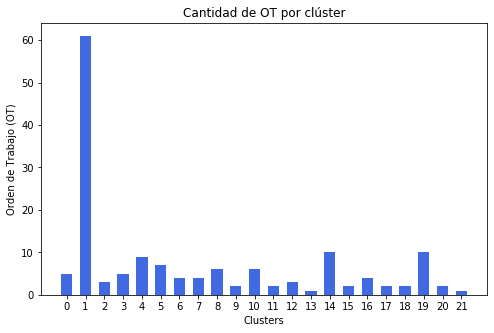

In [81]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=5, width = 0.6, save = save) 

### 6. Petrobras Chile Red Ltda. Salida Norte

In [82]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Petrobras Chile Red Ltda. Salida Norte'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

108

Número óptimo de clústers: 22


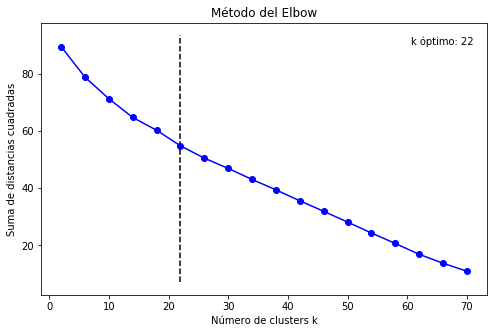

Wall time: 7.11 s


In [83]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=6, save = save)

In [84]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : certificacion srv ano 2019 os de respaldo
	sentence  0 :  certificacion srv ano 2019 os de respaldo
Cluster 1 : area de atencion combustible estanque numero 4 con variacion negativa consecutiva
	sentence  0 :  area de atencion combustible estanque 4 con stock negativo consecutiva
	sentence  1 :  area de atencion combustible estanque 4 sigue cin variacion negativa consecutiva
	sentence  2 :  area de atencion combustible estanque 4 con variacion negativa consecutiva favor revisar
	sentence  3 :  area de atencion combustible variacion acumulada durante tres dias consecutivos
	sentence  4 :  area de atencion combustible estanque 4 tiene 5 dias con variacion negativa
	sentence  5 :  area de atencion combustible estanque numero 4 con variacion negativa consecutiva
	sentence  6 :  area de atencion combustible estanque 4 de 97 con variacion negativa consecutiva por 5 dias
	sentence  7 :  area de atencion combustible variacion negativa consecutiva de gas 97
	sentence  8 :

In [85]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : certificacion srv ano 2019 os de respaldo
Cluster  1 : area de atencion combustible estanque numero 4 con variacion negativa consecutiva
Cluster  2 : area de atencion combustible manguera surtidor 6 gasolina arrancada de la base
Cluster  3 : area de atencion combustible
Cluster  4 : area de atencion combustible veed root con alarma l5 liquido alto
Cluster  5 : detenido gas 9597
Cluster  6 : surtidor 1 y 2 no sale combustible
Cluster  7 : area de atencion combustible breakaway surtidor 7 desconectado
Cluster  8 : area de atencion combustible surtidor 9 y 10 pistolas se salio de la base
Cluster  9 : area de atencion
Cluster  10 : surtidores del 1 al 8 antes de iniciar una carga tiene 20 pesos generados automaticamente
Cluster  11 : area de atencion combustible estanque gasolina 93 con variacion negativa en total estacion
Cluster  12 : area de atencion combustible tapa gorro sin cierre hermetico tanque 2
Cluster  13 : area de atencion combustible surtidor 6 problema en seguro

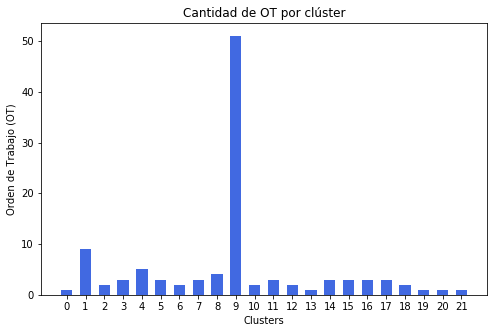

In [86]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=6, width = 0.6,save = save) 

### 7. INVERSIONES ENEX S.A.

In [87]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'INVERSIONES ENEX S.A.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

116

Número óptimo de clústers: 30


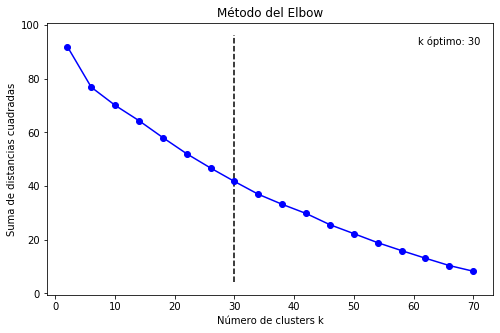

Wall time: 7.12 s


In [88]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=7,save = save)

In [89]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 30
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : pistola danada con fuga de combustible
	sentence  0 :  pistola danada con fuga de combustible
Cluster 1 : programa mantencion preventiva
	sentence  0 :  area de atencion mantencion preventiva solicitado por fono
	sentence  1 :  programacion mantencion preventiva
	sentence  2 :  programacion mantencion preventiva
	sentence  3 :  programacion mantencion preventiva
	sentence  4 :  programacion mantencion preventiva
	sentence  5 :  programacion mantencion preventiva
	sentence  6 :  programacion mantencion preventiva
	sentence  7 :  programacion mantencion preventiva
	sentence  8 :  programacion mantencion preventiva
	sentence  9 :  programacion mantencion preventiva
	sentence  10 :  programacion mantencion preventiva
	sentence  11 :  programacion mantencion preventiva
	sentence  12 :  programacion mantencion preventiva
	sentence  13 :  programacion mantencion preventiva
	sentence  14 :  programacion mantencion preventiva
	sentence  15 :  programa mantencion preventiv

In [90]:
# Clusters representativos (con n = 30)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : pistola danada con fuga de combustible
Cluster  1 : programa mantencion preventiva
Cluster  2 : surtidores 1 2 8 y 9 despachan lento
Cluster  3 : area de atencion isla 1 surtidor emite un pitido intermitente en teclado de programacion solicitado por manuel toro fono
Cluster  4 : manguera de gasolina cortada surtidor 4
Cluster  5 : pistola de 95 octanos surtidor 1 no corta
Cluster  6 : fundas y pistolas deterioradas se solicita cambio
Cluster  7 : surtidores 1 y 2 de combustible y diesel cortan antes de monto programado
Cluster  8 : fuga de combustible por giratorio del surtidor 1 y 2
Cluster  9 : fuga de combustible en brazo de carga
Cluster  10 : surtidor no corta las ventas en lo programado
Cluster  11 : surtidor 1 despacha combustible lento
Cluster  12 : cambio de valvula de despiche de contenedor de estanque numero 2
Cluster  13 : perdida de combustible pistola surtidor 6
Cluster  14 : pistola surtidor 1 de diesel no corta
Cluster  15 : pistola derrama combustible
Clus

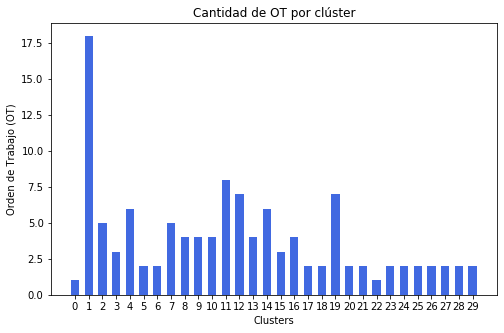

In [91]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=7, width = 0.6, save = save)

### 8. Petrobras Chile Red Ltda- Enea

In [92]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Petrobras Chile Red Ltda- Enea'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

110

Número óptimo de clústers: 18


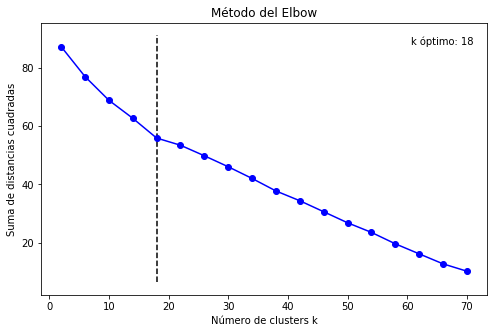

Wall time: 7.22 s


In [93]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=8, save = save)

In [94]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 18
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : area de atencion combustible hola buenas al sacar la pistola se esta adelantando el marcador pensando el clientr que lo estamos estafando
	sentence  0 :  area de atencion combustible hola buenas al sacar la pistola se esta adelantando el marcador pensando el clientr que lo estamos estafando
Cluster 1 : surtidor 9 y 10 diesel despachando muy lento
	sentence  0 :  surtidor 9 y 10 diesel despachando muy lento
	sentence  1 :  surtidor 9 y 10 despachando diesel muy lento nuevamente
	sentence  2 :  surtidor 9 y 10 despachando diesel muy lento
	sentence  3 :  surtidor 9 y 10 diesel despachando lentamente nuevamente ahora en la tarde
	sentence  4 :  surtidor 9 y 10 diesel despacha muy lento
Cluster 2 : area de atencion combustible surtidor 5 bencina cliente se fuga con pistola
	sentence  0 :  area de atencion combustible cliente se llevo la manguera en la fuga
	sentence  1 :  area de atencion combustible surtidor 5 bencina cliente se fuga con pistola
	sentence  2 :  area

In [95]:
# Clusters representativos (con n = 18)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : area de atencion combustible hola buenas al sacar la pistola se esta adelantando el marcador pensando el clientr que lo estamos estafando
Cluster  1 : surtidor 9 y 10 diesel despachando muy lento
Cluster  2 : area de atencion combustible surtidor 5 bencina cliente se fuga con pistola
Cluster  3 : area de atencion combustible se requiere reemplazo de manguera y pistola surtidor 8 el cual fue roto en vehiculo que fugo
Cluster  4 : area de atencion combustible problemas con inicio de carga con surtidor 8 despacho lento y no inicia carga en 0
Cluster  5 : area de atencion
Cluster  6 : area de atencion combustible surtidor 6 diesel filtra combustible desde la union de pistola con manguera
Cluster  7 : area de atencion combustible surtidor 9 no despacha combustible
Cluster  8 : area de atencion combustible hola buenas se esta adelandanto el marcador en el surtidor 8
Cluster  9 : area de atencion combustible surtidores 5 y 6 no comienzan el despacho en 0 cero diesel y bencinas
Cl

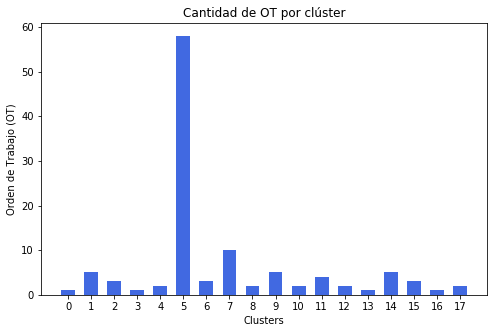

In [96]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=8, width = 0.6, save = save)

### 9. SOCIEDAD COMERCIAL ANTUCO LTDA.

In [97]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'SOCIEDAD COMERCIAL ANTUCO LTDA.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

113

Número óptimo de clústers: 22


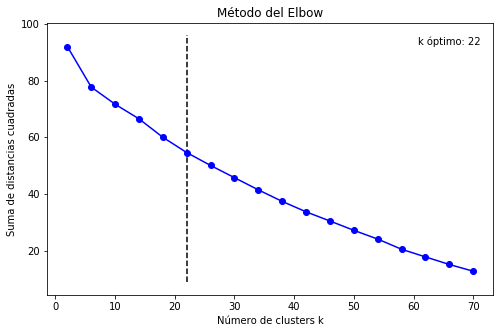

Wall time: 7.29 s


In [98]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=9,save = save)

In [99]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : orden 4 breakaway filtracion se repara pero hoy vuelve a filtrar venta detenida se requiere volver a reparar
	sentence  0 :  orden 4 breakaway filtracion se repara pero hoy vuelve a filtrar venta detenida se requiere volver a reparar
Cluster 1 : area de atencion pistola alto galonaje p diesel filtra combustible se requiere cambio venta detenida solicitado por emilio ramirez fono
	sentence  0 :  area de atencion surtidores 5 y 6 p diesel alto galonaje bloqueados display se pone en cero venta y litros pero no funciona ticket orpack 7 se requiere arreglo solicitado por emilio ramirez fono
	sentence  1 :  area de atencion breakaway isla 8 p diesel danado filtracion de producto solicitado por emilio ramirez fono
	sentence  2 :  area de atencion pistola alto galonaje p diesel filtracion abundante venta detenida solicitado por emilio ramirez fono
	sentence  3 :  area de atencion pistola gas 95 sensor danado solicitado por emilio ramirez fono
	sentence  4 :  area de aten

In [100]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : orden 4 breakaway filtracion se repara pero hoy vuelve a filtrar venta detenida se requiere volver a reparar
Cluster  1 : area de atencion pistola alto galonaje p diesel filtra combustible se requiere cambio venta detenida solicitado por emilio ramirez fono
Cluster  2 : programacion mantencion preventiva
Cluster  3 : isla 1 surtidor alto galonaje diesel pistola danada de boca 1 inoperativa
Cluster  4 : manguera gas 93 isla 3 presenta fuga de combustible venta detenida se requiere cambio urgente
Cluster  5 : manguera suelta del brekawie boca 13 diesel
Cluster  6 : instalacion detector de fuga
Cluster  7 : area de atencion solicito cambio funda de pistola diesel gas 93 gas 97 estan danadas solicitado por bernardo silva fono
Cluster  8 : displey de isla 7 y 8 p diesel apagado cliente no visualiza venta se requiere cambio de ampolleta
Cluster  9 : area de atencion bocas despachan sumante lento peso a peso solicitado por bernardo silva fono
Cluster  10 : pistola al parecer dana

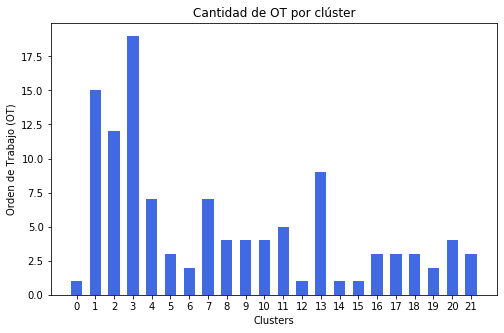

In [101]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=9, width = 0.6, save = save)

### 10. Comercial Albano Ltda.

In [102]:
# SELECCIONANDO UNA ESTACIÓN EN PARTICULAR 
df = df_total[df_total['Estacion'] == 'Comercial Albano Ltda.'] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

101

Número óptimo de clústers: 22


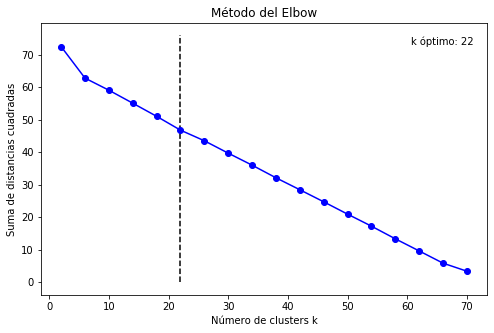

Wall time: 7.22 s


In [103]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences,namecol=namecol, nro_top=10,save = save)

In [104]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

sentences = sentences
nclusters= 22
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : area de atencion combustible veeder root suena todo el dia y no funciona y hace dos semana supo una incidencia por el tema del agua y hasta la fecha no han ido a ver que sucede con esta situacion
	sentence  0 :  area de atencion combustible veeder root suena todo el dia y no funciona y hace dos semana supo una incidencia por el tema del agua y hasta la fecha no han ido a ver que sucede con esta situacion
Cluster 1 : area de atencion
	sentence  0 :  area de atencion combustible dispensador n 1 despacha combustible sin solicitar paulina besoai
	sentence  1 :  area de atencion
	sentence  2 :  area de atencion combustible revisar las tapas de los estanques por que no se ve nada y puede crear una confucion en la descarga de combustible paulina
	sentence  3 :  area de atencion combustible maquina se corta antes de lo programado paulina besso
	sentence  4 :  area de atencion
	sentence  5 :  area de atencion combustible surtidor completo bloqueado le parpadea y sale el n

In [105]:
# Clusters representativos (con n = 22)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : area de atencion combustible veeder root suena todo el dia y no funciona y hace dos semana supo una incidencia por el tema del agua y hasta la fecha no han ido a ver que sucede con esta situacion
Cluster  1 : area de atencion
Cluster  2 : mantencion preventiva mes de septiembre
Cluster  3 : toma de muestra gas 93 tanque 3 id muestra m93l3mcp84 n de acta 84
Cluster  4 : area de atencion combustible
Cluster  5 : area de atencion combustible se cae sistema y se quedo el boton pegado no se puede reiniciar no puede hacer ventas en toda la estacion paulina besoain
Cluster  6 : surtidor 5 y 6 se detienen antes de lo programado o marcan numeros sin tener contacto con la maquina
Cluster  7 : area de atencion combustible cliente indica que tiene alarma de agua alta paulina besoain
Cluster  8 : toma de muestra mes de septiembre
Cluster  9 : area de atencion combustible dispensador n 7 y 8 inhabilitado en ambos costado ya que tiene error en pos de venta y esta arrojando ventas sin con

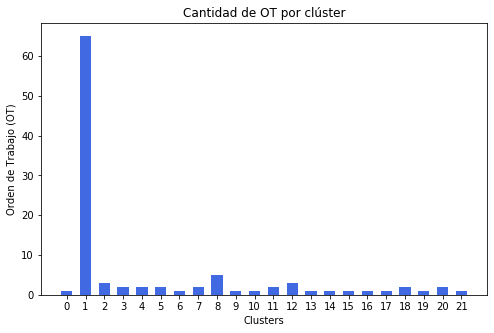

In [106]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, namecol = namecol , nro_top=10, width = 0.6, save = save)